<a href="https://colab.research.google.com/github/dsevero/generative-models/blob/master/experiments/GAN/notebooks/goodfellow_2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Nets (Goodfellow 2014)
https://arxiv.org/pdf/1406.2661.pdf

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
%matplotlib inline

In [30]:
# necessary for autograd compatibility
!pip install scipy==1.1.0 -q

# update tensorflow
!pip install tensorflow==2.0.0b1 -q

ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import autograd.numpy as np
import autograd.numpy.random as npr
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from autograd import grad
from autograd.misc import flatten
from autograd.misc.optimizers import adam, rmsprop, sgd
from scipy.stats import norm


warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')

## Definitions and Tests

In [0]:
# reference: 
# https://github.com/HIPS/autograd/blob/master/examples/generative_adversarial_net.py

def relu(x):       
    return np.maximum(0, x)

def sigmoid(x):    
    return 0.5 * (np.tanh(x) + 1.0)

def logsigmoid(x): 
    return x - np.logaddexp(0, x)

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def neural_net_predict(params, inputs, use_batch_norm=True):
    """Params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix."""
    inpW, inpb = params[0]
    inputs = relu(np.dot(inputs, inpW) + inpb)
    for W, b in params[1:-1]:
        outputs = np.dot(inputs, W) + b
        if use_batch_norm:
            outputs = batch_normalize(outputs)
        inputs = relu(outputs)
    outW, outb = params[-1]
    outputs = np.dot(inputs, outW) + outb
    return outputs

def generator(params, noise):
    samples = neural_net_predict(params, noise)
    return sigmoid(samples)

def discriminator(params, inputs):
    samples = neural_net_predict(params, inputs)
    return sigmoid(samples)

In [0]:
params = 5*((np.eye(3), np.zeros(3)),)
x =  npr.randn(9).reshape((3,3))
zeros = np.array([0, 0, 0])

assert (batch_normalize(zeros) == zeros).all()
assert (batch_normalize(np.array([-1, 1])) == np.array([-0.5, 0.5])).all()
assert (batch_normalize(np.array([[-1, 1], [-2, 2]])) == np.array([[1/3, -1/3], [-1/3, 1/3]])).all()

assert (neural_net_predict(params, x, False) == relu(x)).all()

## 5 Experiments (MNIST)

In [41]:
# Training parameters
param_scale = 0.001
batch_size = 100 # must divide 70_000.
num_epochs = 50
num_batches = int(70_000/batch_size)


# Load, concatenate and reshape the data.
# Here we don't distinguish between train and test.
# Final dimensions are (batch, image_example, image_row, image_column)
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
images = (np.concatenate((train_images, test_images))
            .reshape((num_batches, batch_size, 28, 28))) / 255

# Model hyper-parameters
noise_dim = 10
gen_layer_sizes = [noise_dim, 200, 784]
dsc_layer_sizes = [gen_layer_sizes[-1], 200, 1]

# Initialize NN params. for G and D
init_gen_params = init_random_params(param_scale, gen_layer_sizes)
init_dsc_params = init_random_params(param_scale, dsc_layer_sizes)

print('images.shape:', images.shape)

images.shape: (700, 100, 28, 28)


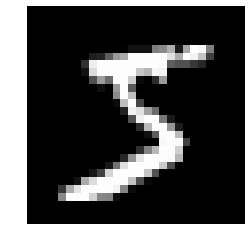

In [36]:
# Real image
show_image(images[0, 0])

array([[0.50065436]])

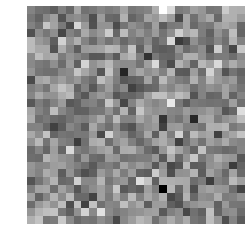

In [37]:
# Initial random image from G
z = random.rand(1, noise_dim)
fake_image = generator(init_gen_params, z)
show_image(fake_image.reshape(28, 28))

# What D knows about the random image (i.e. nothing!)
discriminator(init_dsc_params, fake_image)

In [38]:
# Even real images he has no clue on what is going on!
five_real_images = images[0, :5]
discriminator(init_dsc_params, five_real_images.reshape(5, 28*28))

array([[0.50073763],
       [0.50070626],
       [0.50067908],
       [0.50075126],
       [0.50075905]])

In [42]:
# Train
n_dsc_steps = 1
params_dsc = init_dsc_params
opt = sgd

def objective_outer(params_gen, t):
    global params_dsc
    real_data = images[t % num_batches].reshape(batch_size, 28*28)
    
    def objective_inner(params_dsc, t):
        noise_inner = npr.rand(batch_size, noise_dim)
        fake_data_inner = generator(params_gen, noise_inner)
        return(np.log(discriminator(params_dsc, real_data)).mean() + 
               np.log(1 - discriminator(params_dsc, fake_data_inner))).mean()
        
    params_dsc = opt(grad(objective_inner), params_dsc,
                     step_size=0.01, num_iters=n_dsc_steps)
    
    noise_outer = npr.rand(batch_size, noise_dim)
    fake_data_outer = generator(params_gen, noise_outer)
    return np.log(discriminator(params_dsc, fake_data_outer)).mean()

def callback(params_gen, t, gradient):
    noise = npr.rand(batch_size, noise_dim)
    fake_data = generator(params_gen, noise)
    real_data = images[t % num_batches].reshape(batch_size, 28*28)
    probs_fake = discriminator(params_dsc, fake_data).mean()
    probs_real = discriminator(params_dsc, real_data).mean()
    print(f'Finished iteration {t}; Average real probs: {probs_real}; Average fake probs: {probs_fake}')

params_gen = opt(grad(objective_outer), 
                 init_gen_params,
                 step_size=0.01,
                 num_iters=num_epochs*num_batches,
                 callback=callback)

Finished iteration 0; Average real probs: Autograd ArrayBox with value 0.4989924682552968; Average fake probs: Autograd ArrayBox with value 0.49910606906369503
Finished iteration 1; Average real probs: Autograd ArrayBox with value 0.49900223898352863; Average fake probs: Autograd ArrayBox with value 0.499121746106325
Finished iteration 2; Average real probs: Autograd ArrayBox with value 0.4989909211909748; Average fake probs: Autograd ArrayBox with value 0.49913731241520215
Finished iteration 3; Average real probs: Autograd ArrayBox with value 0.49898959182098684; Average fake probs: Autograd ArrayBox with value 0.4991531113715583
Finished iteration 4; Average real probs: Autograd ArrayBox with value 0.49899491108040295; Average fake probs: Autograd ArrayBox with value 0.49916886164794294
Finished iteration 5; Average real probs: Autograd ArrayBox with value 0.4989944515493327; Average fake probs: Autograd ArrayBox with value 0.49918480595009274
Finished iteration 6; Average real probs

KeyboardInterrupt: ignored

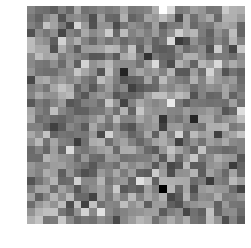

In [43]:
# Initial random image from G
z = npr.rand(1, noise_dim)
fake_image = generator(params_gen, z)
show_image(fake_image.reshape(28, 28))